small dataset + without data balancing + without attention mecanisme

In [ ]:
pip install torch torchvision numpy matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [1]:
# Enhanced Crop Disease Classification with Advanced Augmentation and Training

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import models
from collections import Counter
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt

c:\Users\DELL\intelpython3\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# ==============================
# 1. Custom Dataset with Albumentations
# ==============================
class AlbumentationsDataset(Dataset):
    def __init__(self, image_folder_dataset, transform=None):
        self.image_folder_dataset = image_folder_dataset
        self.transform = transform

    def __getitem__(self, idx):
        image_path, label = self.image_folder_dataset.samples[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

    def __len__(self):
        return len(self.image_folder_dataset)



In [3]:
# ==============================
# 2. Augmentations
# ==============================
def get_train_transforms():
    return A.Compose([
        A.Resize(512, 512),
        A.RandomCrop(448, 448),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(blur_limit=3, p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def get_val_test_transforms():
    return A.Compose([
        A.Resize(448, 448),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

# ==============================
# 3. DataLoader
# ==============================
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from collections import Counter  # Not used anymore but included in case used elsewhere
# Make sure to import your AlbumentationsDataset and transformation functions

def create_dataloaders(data_dir, batch_size=16, train_ratio=0.7, val_ratio=0.15):
    raw_dataset = ImageFolder(root=data_dir)
    total_size = len(raw_dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    train_set, val_set, test_set = random_split(raw_dataset, [train_size, val_size, test_size])

    train_dataset = AlbumentationsDataset(train_set.dataset, transform=get_train_transforms())
    val_dataset = AlbumentationsDataset(val_set.dataset, transform=get_val_test_transforms())
    test_dataset = AlbumentationsDataset(test_set.dataset, transform=get_val_test_transforms())

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    print(f"Number of images after augmentation:")
    print(f"Train: {len(train_set)} images")
    print(f"Validation: {len(val_set)} images")
    print(f"Test: {len(test_set)} images")

    return train_loader, val_loader, test_loader, raw_dataset.classes


In [4]:
# ==============================
# Self-Attention Block for Feature Maps
# ==============================
class SelfAttention2D(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention2D, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query_conv(x).view(B, -1, H * W).permute(0, 2, 1)   # (B, HW, C')
        proj_key = self.key_conv(x).view(B, -1, H * W)                        # (B, C', HW)
        energy = torch.bmm(proj_query, proj_key)                             # (B, HW, HW)
        attention = F.softmax(energy, dim=-1)                                # (B, HW, HW)

        proj_value = self.value_conv(x).view(B, -1, H * W)                   # (B, C, HW)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))              # (B, C, HW)
        out = out.view(B, C, H, W)                                           # (B, C, H, W)

        out = self.gamma * out + x
        return out

# ==============================
# 5. Modified Model with Self-Attention
# ==============================
class CropDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super(CropDiseaseModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = True
        self.backbone.fc = nn.Identity()
        self.attention = SelfAttention2D(2048)  # ResNet50 final feature map channels
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)             # (B, 2048)
        x = x.view(x.size(0), 2048, 1, 1)
        x = F.interpolate(x, size=(7, 7), mode='bilinear')  # Upsample to spatial map
        x = self.attention(x)            # Apply self-attention
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)  # Global pooling
        x = self.dropout(x)
        x = self.fc(x)
        return x



# ==============================
# 6. Plotting Function
# ==============================
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(val_accuracies, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==============================
# 7. Training Function
# ==============================
def train(model, train_loader, val_loader, epochs=10, lr=0.001, save_path="best_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"\u2705 Best model saved at epoch {epoch+1} with val acc: {val_acc:.4f}")

        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)



In [ ]:
# ==============================
# 5. MAIN SCRIPT
# ==============================
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/PFE_dataset_a"

Mounted at /content/drive


✅ Dataset found at: /content/drive/My Drive/PFE_dataset_a
Files: ['Common Root Rot', 'Yellow', 'Pawdery_mildew', 'Septoria', 'Stem', 'Loose Smut', 'Fusarium', 'Tan Spot', 'Brown']


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments o

Number of images after augmentation:
Train: 2472 images
Validation: 529 images
Test: 531 images


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


✅ Best model saved at epoch 1 with val acc: 0.8596
Epoch [1/25] | Train Loss: 1.3776 | Val Loss: 0.8585 | Train Acc: 0.6090 | Val Acc: 0.8596
✅ Best model saved at epoch 2 with val acc: 0.9485
Epoch [2/25] | Train Loss: 0.8845 | Val Loss: 0.6768 | Train Acc: 0.8514 | Val Acc: 0.9485
✅ Best model saved at epoch 3 with val acc: 0.9700
Epoch [3/25] | Train Loss: 0.7561 | Val Loss: 0.6363 | Train Acc: 0.9080 | Val Acc: 0.9700
✅ Best model saved at epoch 4 with val acc: 0.9740
Epoch [4/25] | Train Loss: 0.7175 | Val Loss: 0.6250 | Train Acc: 0.9295 | Val Acc: 0.9740
✅ Best model saved at epoch 5 with val acc: 0.9873
Epoch [5/25] | Train Loss: 0.7006 | Val Loss: 0.5897 | Train Acc: 0.9354 | Val Acc: 0.9873
Epoch [6/25] | Train Loss: 0.6792 | Val Loss: 0.5850 | Train Acc: 0.9400 | Val Acc: 0.9867
✅ Best model saved at epoch 7 with val acc: 0.9907
Epoch [7/25] | Train Loss: 0.6519 | Val Loss: 0.5766 | Train Acc: 0.9524 | Val Acc: 0.9907
✅ Best model saved at epoch 8 with val acc: 0.9921
Epoch 

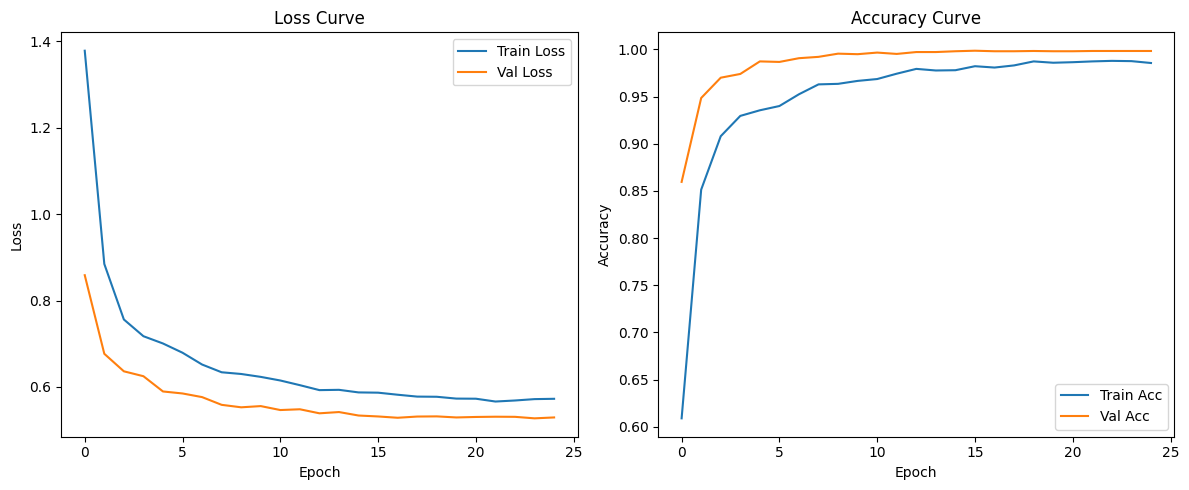

In [ ]:
if __name__ == "__main__":
    if os.path.exists(data_path):
        print("✅ Dataset found at:", data_path)
        print("Files:", os.listdir(data_path))
        train_loader, val_loader, test_loader, classes = create_dataloaders(data_path, batch_size=16)
        model = CropDiseaseModel(num_classes=len(classes))
        train(model, train_loader, val_loader, epochs=25, lr=0.001, save_path="best_model.pth")
    else:
        print("❌ Error: Dataset path not found!")

In [ ]:
torch.save(model.state_dict(), "M2.pth")

In [13]:
from google.colab import files
import torch
files.download('M2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 99.83%
Recall: 0.9977
F1 Score: 0.9979


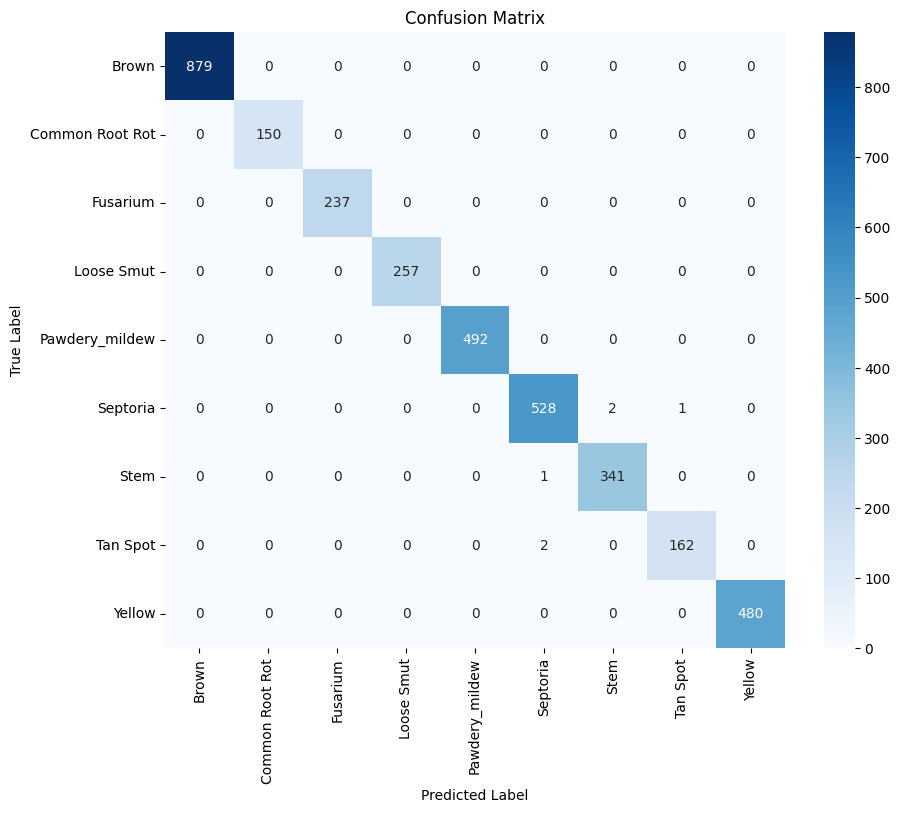

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

# ==============================
# TESTING FUNCTION
# ==============================
def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient calculation during testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Get predictions
            _, preds = torch.max(outputs, 1)  # Get class with highest probability

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average="macro")  # Use "macro" to consider all classes equally
    f1 = f1_score(all_labels, all_preds, average="macro")  # F1-score (macro-averaged)

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm, accuracy, recall, f1

# ==============================
# PLOT CONFUSION MATRIX
# ==============================
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# ==============================
# RUN TESTING
# ==============================
if __name__ == "__main__":
    cm, test_accuracy, test_recall, test_f1 = test(model, test_loader)
    plot_confusion_matrix(cm, classes)


Top 3 classes prédictes :
1. Tan Spot: 0.9744
2. Septoria: 0.0075
3. Yellow: 0.0042


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


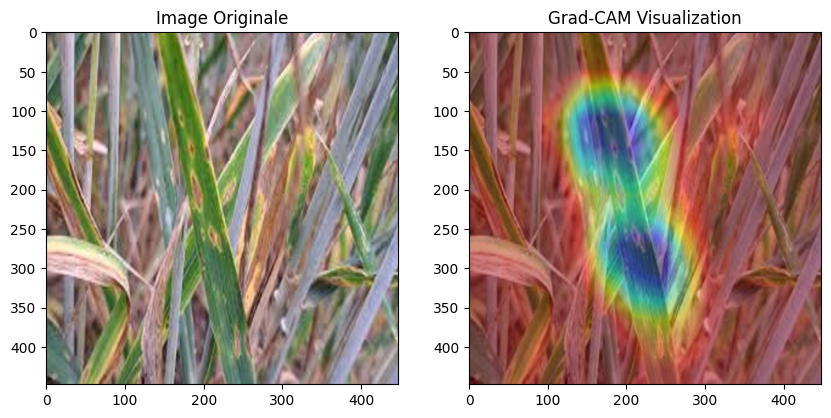

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.nn.functional as F

# Charger le modèle entraîné
model = CropDiseaseModel(num_classes=len(classes))  # Assurez-vous que 'classes' est défini
model.load_state_dict(torch.load("M2.pth", map_location=torch.device("cpu")))
model.eval()

# Transformer l'image pour le modèle
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.CenterCrop((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Charger l'image de test
image_path = "test.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Ajouter une dimension batch

# Passer l'image à travers le modèle
output = model(input_tensor)
probabilities = torch.nn.functional.softmax(output, dim=1)  # Convertir en probabilités

# Obtenir les 3 classes avec les probabilités les plus élevées
top3_prob, top3_indices = torch.topk(probabilities, 3)

# Afficher les classes et probabilités correspondantes
print("Top 3 classes prédictes :")
for i in range(3):
    class_name = classes[top3_indices[0][i].item()]
    probability = top3_prob[0][i].item()
    print(f"{i+1}. {class_name}: {probability:.4f}")

# Utiliser la classe avec la plus haute probabilité pour Grad-CAM
predicted_class = top3_indices[0][0].item()  # ✅ Fix: Now we define predicted_class

### 📌 Grad-CAM Implementation ###
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook pour capturer les gradients
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation_maps = output  # Sauvegarde des activations

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Sauvegarde des gradients

    def generate_heatmap(self, input_tensor, target_class):
        # Faire une passe avant
        output = self.model(input_tensor)
        self.model.zero_grad()

        # Calculer le gradient de la classe cible
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot)

        # Moyenne des gradients
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        heatmap = torch.sum(weights * self.activation_maps, dim=1).squeeze()

        # Appliquer ReLU et normaliser
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.detach().cpu().numpy()

# Sélectionner la dernière couche de convolution du modèle (ex: ResNet50)
target_layer = model.backbone.layer4[-1]  # Modifier selon votre modèle
grad_cam = GradCAM(model, target_layer)

# Générer la carte de chaleur Grad-CAM pour la classe la plus probable
heatmap = grad_cam.generate_heatmap(input_tensor, predicted_class)

# Superposer sur l'image originale
heatmap = cv2.resize(heatmap, (448, 448))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convertir l'image originale en NumPy
image_np = np.array(image.resize((448, 448)))
superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Image Originale")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Visualization")

plt.show()


c:\Users\DELL\intelpython3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\intelpython3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Top 3 classes prédictes :
1. Pawdery_mildew: 0.9142
2. Fusarium: 0.0280
3. Loose Smut: 0.0160


c:\Users\DELL\intelpython3\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


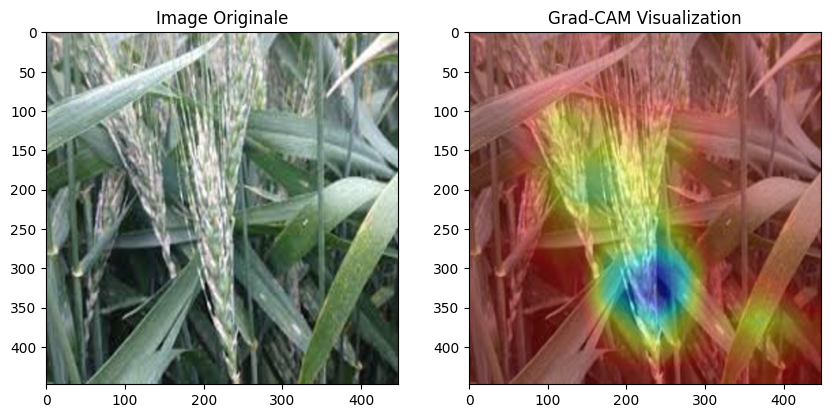

In [5]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.nn.functional as F

# Charger le modèle entraîné
classes = [
    "Brown", 
    "Common Root Rot", 
    "Fusarium", 
    "Loose Smut", 
    "Pawdery_mildew", 
    "Septoria", 
    "Stem", 
    "Tan Spot", 
    "Yellow"
]

model = CropDiseaseModel(num_classes=len(classes))  # Assurez-vous que 'classes' est défini
model.load_state_dict(torch.load("M2_selfAttention.pth", map_location=torch.device("cpu")))
model.eval()

# Transformer l'image pour le modèle
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.CenterCrop((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Charger l'image de test
image_path = "test.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Ajouter une dimension batch

# Passer l'image à travers le modèle
output = model(input_tensor)
probabilities = torch.nn.functional.softmax(output, dim=1)  # Convertir en probabilités

# Obtenir les 3 classes avec les probabilités les plus élevées
top3_prob, top3_indices = torch.topk(probabilities, 3)

# Afficher les classes et probabilités correspondantes
print("Top 3 classes prédictes :")
for i in range(3):
    class_name = classes[top3_indices[0][i].item()]
    probability = top3_prob[0][i].item()
    print(f"{i+1}. {class_name}: {probability:.4f}")

# Utiliser la classe avec la plus haute probabilité pour Grad-CAM
predicted_class = top3_indices[0][0].item()  # ✅ Fix: Now we define predicted_class

### 📌 Grad-CAM Implementation ###
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook pour capturer les gradients
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation_maps = output  # Sauvegarde des activations

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Sauvegarde des gradients

    def generate_heatmap(self, input_tensor, target_class):
        # Faire une passe avant
        output = self.model(input_tensor)
        self.model.zero_grad()

        # Calculer le gradient de la classe cible
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot)

        # Moyenne des gradients
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        heatmap = torch.sum(weights * self.activation_maps, dim=1).squeeze()

        # Appliquer ReLU et normaliser
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.detach().cpu().numpy()

# Sélectionner la dernière couche de convolution du modèle (ex: ResNet50)
target_layer = model.backbone.layer4[-1]  # Modifier selon votre modèle
grad_cam = GradCAM(model, target_layer)

# Générer la carte de chaleur Grad-CAM pour la classe la plus probable
heatmap = grad_cam.generate_heatmap(input_tensor, predicted_class)

# Superposer sur l'image originale
heatmap = cv2.resize(heatmap, (448, 448))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convertir l'image originale en NumPy
image_np = np.array(image.resize((448, 448)))
superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Image Originale")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Visualization")

plt.show()
